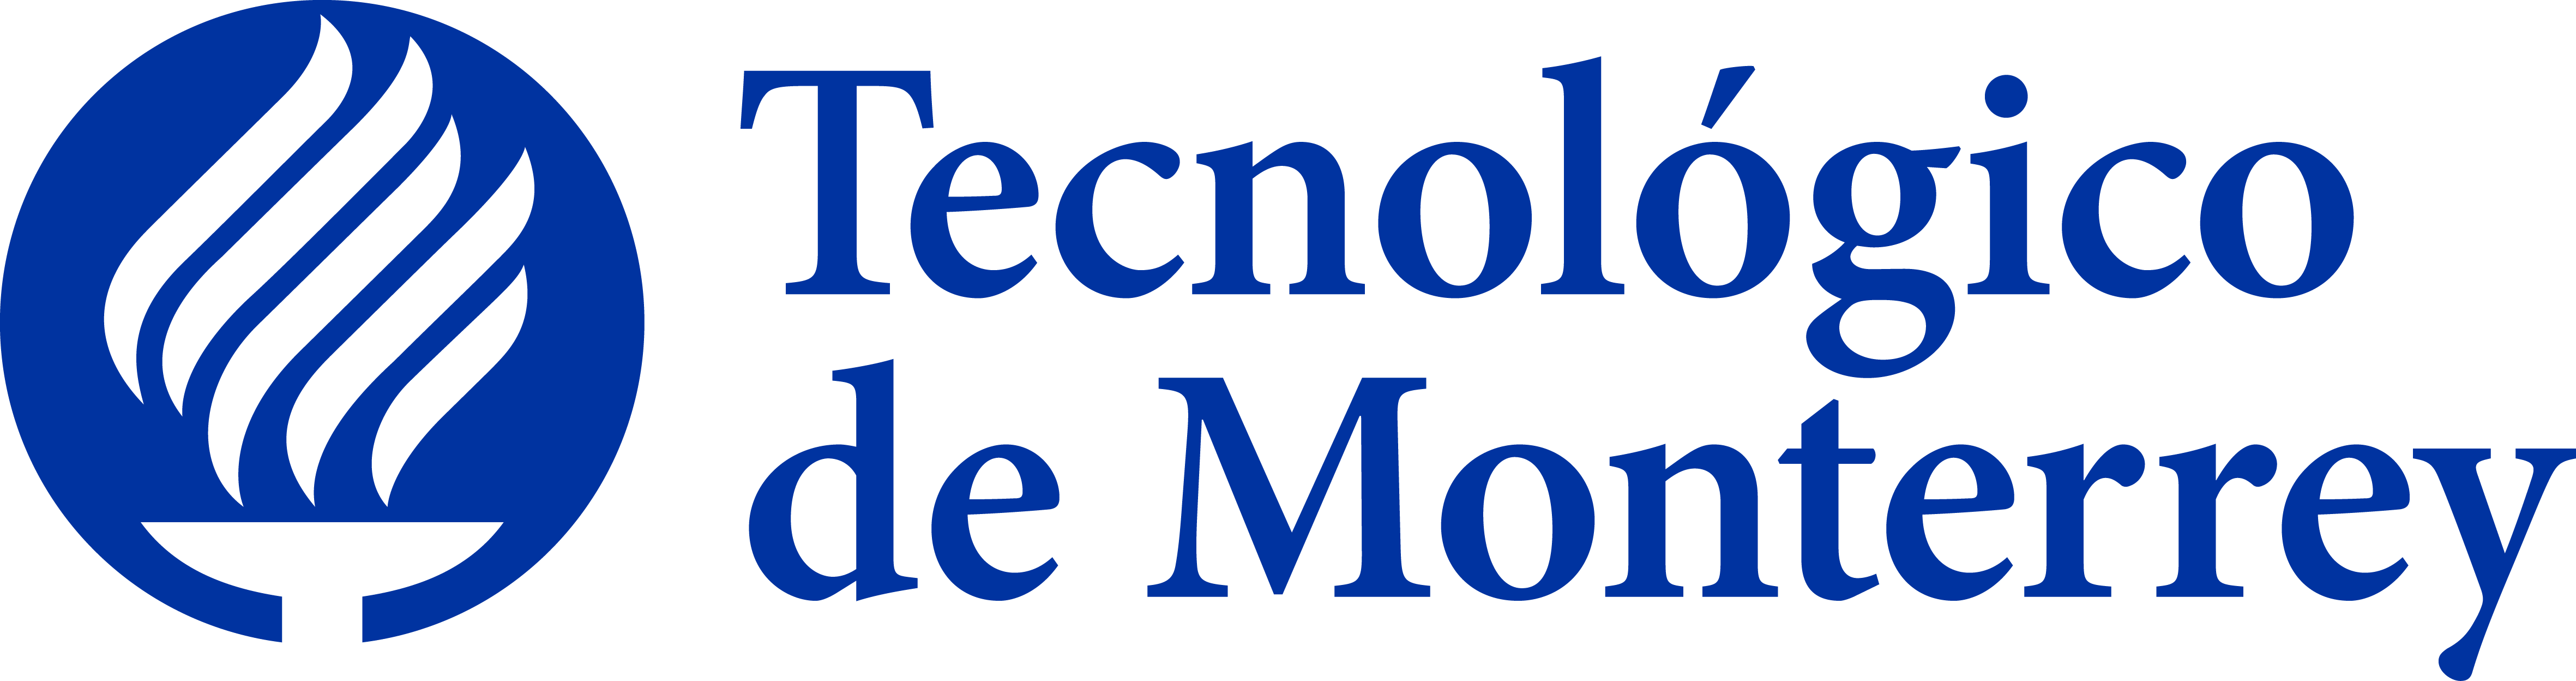

# **Master in Artificial Intelligence**

### Course: **Machine Learning Operations**

### Tecnológico de Monterrey

### Lead Dr. Gerardo Rodriguez Hernandez

## Team 33
* A01794457 Iossif Moisés Palli Laura
* A01794765 Pablo César Mecate Pantoja
* A01209133 Luis Fernando Rivera Albarrán
* A01794940 José de Jesús Peña Rodríguez
* A01795093 Miguel Angel Alpizar Flores

# Setup

In [ ]:
#Iniciando

In [ ]:
import pandas as pd
import os
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

ModuleNotFoundError: No module named 'sklearn'

# Loading the data

In [ ]:
#Get route of the path
current_path = os.getcwd()
aux_curr_path = current_path
project_path = aux_curr_path.replace('/notebooks', '')
dataset_path = "dataset/CEE_DATA.arff"
dataset_path = os.path.join(project_path, dataset_path)

data, meta = arff.loadarff(dataset_path)

df = pd.DataFrame(data)
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x) #Encoding from byte to string
df.info()

<Axes: title={'center': 'Relationship between Performance'}>

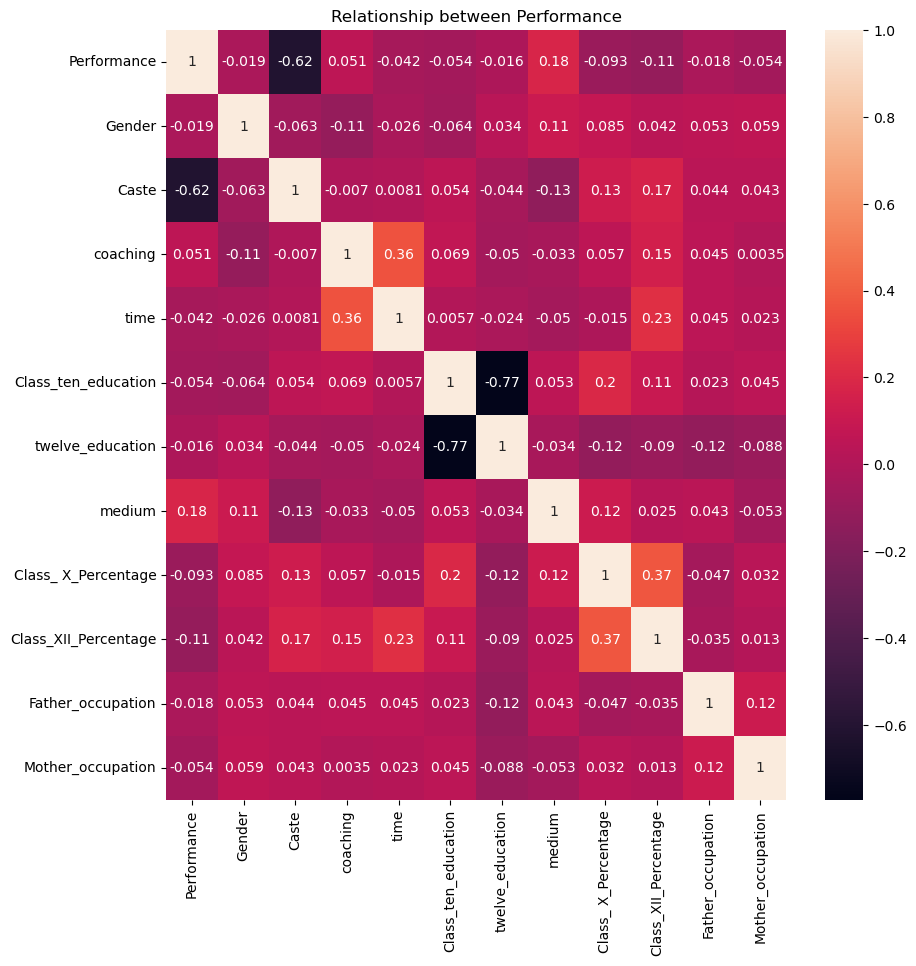

In [ ]:
# Looking at the correlations
df_ordinal= df.copy()

cat_encoder= LabelEncoder()
lista_colmuns= [col for col in df_ordinal.columns]
for col in lista_colmuns:
  df_ordinal[col]=cat_encoder.fit_transform(df_ordinal[col])

corr_matrix=df_ordinal.corr()
plt.figure(figsize=(10,10))
plt.title(f'Relationship between Performance')
sns.heatmap(corr_matrix,annot=True)

            #0 : Average -  157
            #1 : Excellent - 101
            #2 : Good - 210
            #3 : Very Good - 198

Performance
Good         210
Vg           198
Average      157
Excellent    101
Name: count, dtype: int64


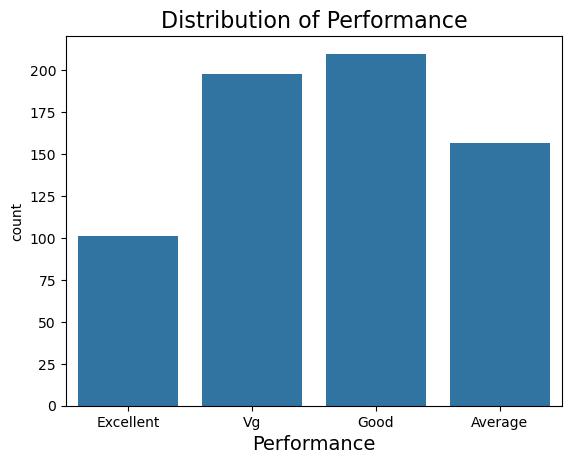

In [ ]:
ax = sns.countplot(data=df, x="Performance")
plt.title(f'Distribution of {"Performance"}', fontsize=16)
plt.xlabel("Performance", fontsize=14)

print(df["Performance"].value_counts())

# Preprocessing and Feature Engineering

In [ ]:
columns_of_interest=["Performance",'Class_ X_Percentage', 'Class_XII_Percentage', 'medium', 'Caste']
updated_df=df[columns_of_interest]

In [ ]:
X=updated_df.drop('Performance',axis=1)
y= updated_df[['Performance']]

In [ ]:
#Create oneHot enconder object
enc_OneHot = OneHotEncoder(sparse_output=False)

#Columns to apply one hot enconder
col_X=['Class_ X_Percentage', 'Class_XII_Percentage', 'medium', 'Caste']


#Create the transformer
ct= ColumnTransformer(
    transformers=[
    ("OneHotInXColumns", enc_OneHot,col_X)
                      ]
)

#Create Label encoder object
ord_enc=LabelEncoder()


In [ ]:
# Applying OneHot to X
X = ct.fit_transform(X)
#Applying OneHot
y_OneHot = enc_OneHot.fit_transform(y)

#Applying LabelEnconder to y
df["y_ord_enc"]=ord_enc.fit_transform(y)
y_Label = df["y_ord_enc"]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Splitting the dataset

In [ ]:
#Split the dataset for y_OneHot
X_train, X_test, y_train_OneHot, y_test_OneHot = train_test_split(X, y_OneHot, test_size=0.2, random_state=42)

#Split the dataset for y_Label
X_train, X_test, y_train_Label, y_test_Label = train_test_split(X, y_Label, test_size=0.2, random_state=42)

In [ ]:

Experiments = [
    (
        "Random Forest n_estimators=100",
        RandomForestClassifier(class_weight="balanced"),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),

    (
        "XGBoost",
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),

    (
         "Multinomial Logistic Regression",
        LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    ),

     (
        "K-Nearest Neighbors",
        KNeighborsClassifier(n_neighbors=5),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    ),

    (
        "MLP",
        MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam'),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),

    (
        "Support Vector Classifier",
        SVC(kernel='linear', probability=True),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    )


]


In [ ]:
results_per_model = []

for model_name, model, train_set, test_set in Experiments:
    X_train = train_set[0] #get Xtrain from the list models
    y_train = train_set[1] #get y_train from list models
    X_test = test_set[0]    #get x_test from list models
    y_test = test_set[1]   #get y_test from list models

    model.fit(X_train, y_train)  #train the current model
    y_pred = model.predict(X_test) #make predictions
    report = classification_report(y_test, y_pred, output_dict=True) #make a dict of the classification report


    results_per_model.append(report) #add the previus dict to a list

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic

# Publish experiements to server

In [ ]:
mlflow.set_experiment("Student Performance Analysis Model")
mlflow.set_tracking_uri("http://3.84.228.208:5000")

for i, element in enumerate(Experiments):
    model_name = element[0]
    model = element[1]
    report = results_per_model[i]

    with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model", model_name)


            # -------------Class interpretation----------------
            #0 : Average
            #1 : Excellent
            #2 : Good
            #3 : Very Good

            #Metrics of class 0

            mlflow.log_metric('acurracy_class_0', report['0']['precision'])
            mlflow.log_metric('recall_class_0', report['0']['recall'])
            mlflow.log_metric('f1_class_0', report['0']['f1-score'])

            #Metrics of class 1

            mlflow.log_metric('acurracy_class_1', report['1']['precision'])
            mlflow.log_metric('recall_class_1', report['1']['recall'])
            mlflow.log_metric('f1_class_1', report['1']['f1-score'])

            #Metrics of class 2

            mlflow.log_metric('acurracy_class_2', report['2']['precision'])
            mlflow.log_metric('recall_class_2', report['2']['recall'])
            mlflow.log_metric('f1_class_2', report['2']['f1-score'])

            #Metrics of class 3

            mlflow.log_metric('acurracy_class_3', report['3']['precision'])
            mlflow.log_metric('recall_class_3', report['3']['recall'])
            mlflow.log_metric('f1_class_3', report['3']['f1-score'])


            if "XGB" in model_name:
                mlflow.xgboost.log_model(model, "model")
            else:
                mlflow.sklearn.log_model(model, "model")

2024/10/18 21:05:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 21:06:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest n_estimators=100 at: http://3.84.228.208:5000/#/experiments/642836926125242626/runs/c290b20e558444788a54305895227786.
2024/10/18 21:06:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://3.84.228.208:5000/#/experiments/642836926125242626.
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/10/18 21:06:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_ex